In [65]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
import os
from os.path import join
import xarray as xr
import pandas as pd
from scipy import interpolate

import math
import time
import copy 
import datetime
import random
import itertools
import math
import sys  

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.preprocessing import preprocess

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils
from soundings.utils import radiosonde_products

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

vol = '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/'
# vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Thu Jul 16 13:15:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   37C    P8    18W / 250W |     62MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                      

In [2]:
xar = xr.open_dataset(vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

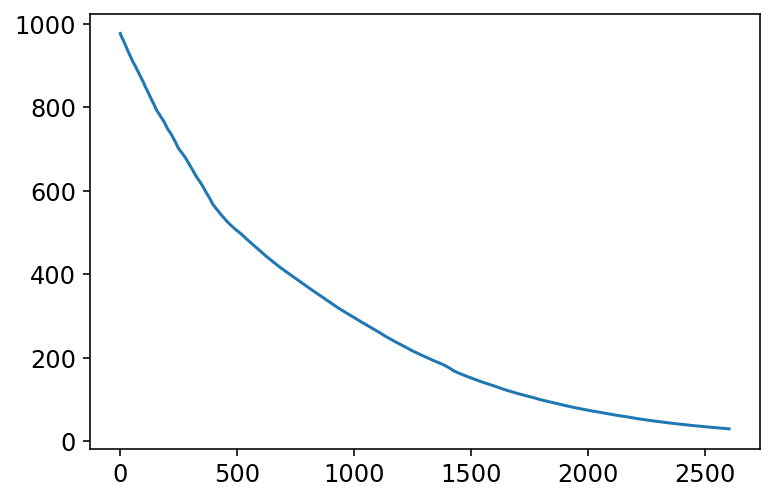

In [6]:
plt.plot(p);

In [17]:
from scipy import interpolate

def interpolate_profile(y, sonde_profile_dims=4000):
    f = interpolate.interp1d(np.arange(len(y)), y, kind='linear')
    return f(np.linspace(0, len(y) - 1, sonde_profile_dims))

pi = interpolate_profile(p)
ti = interpolate_profile(t)

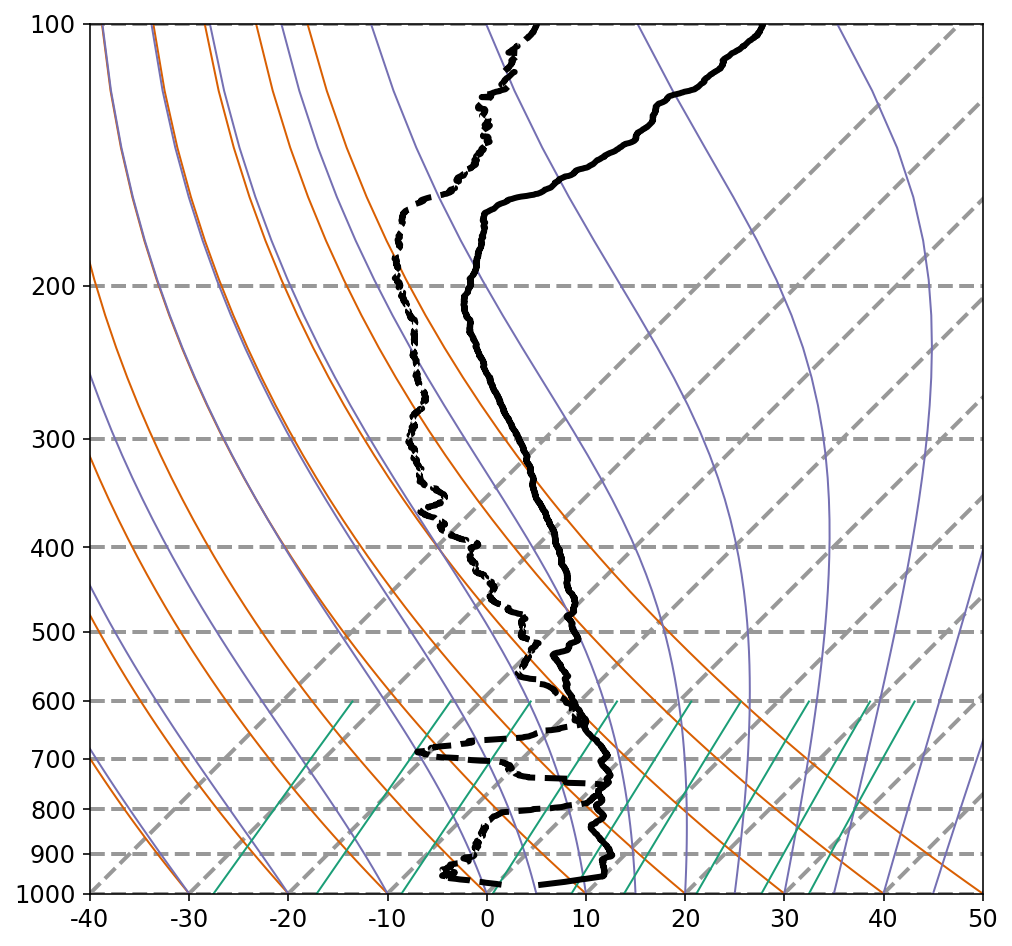

In [3]:
sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [146]:
SONDE_PROFILE_DIMS = 2000
SIGMA = 0
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= 1000 and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

def plot_results(nnet, X, T, index=0, loss=True):
    
    sounding_dict_for_metpy = dict()

    if len(X.shape) > 2:
        P = X[index,:,PRESSURE]
    else:
        # (n, p_dim + t_dim + td_dim)
        P = X[index,:SONDE_PROFILE_DIMS]

    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]
    
    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)
    if loss:
        fig, ax = plt.subplots(1, figsize=(8, 4))

        ax.plot(nnet.history['loss'], label='train')
        ax.plot(nnet.history['val_loss'], label='val')
        ax.legend();
    
def mean_pressure_errors(nnet, X, T):
    error = np.abs((nnet.use(X) - T))
    pressures = X[:,:,PRESSURE]
    # Create linearly spaced bins from the min to max pressure
    bins = np.linspace(pressures.min(), pressures.max() + 1, pressures.shape[1])
    # Indicies of where which bin pressure values belong
    pressure_bin_indicies = np.digitize(pressures, bins)
    
    mean_error = np.zeros(bins.size)
    # Mean error corresponding to each bin of pressure levels
    for bin_index in range(bins.size):
        vals = error[pressure_bin_indicies == bin_index]
        mean = np.mean(vals) if vals.size > 0 else 0
        mean_error[bin_index] = mean
        
    # trim mean 0's from ends
    s = 0
    for i in range(mean_error.size):
        if mean_error[i] != 0:
            s = i
            break
    e = mean_error.size
    for i in range(mean_error.size-1, 0, -1):
        if mean_error[i] != 0:
            e = i
            break

    mean_error = mean_error[s:e+1]
    bins = bins[s:e+1]
    
    return mean_error, bins

time: 26.320, avg: 0.025 seconds
2001: 874/1037 are valid


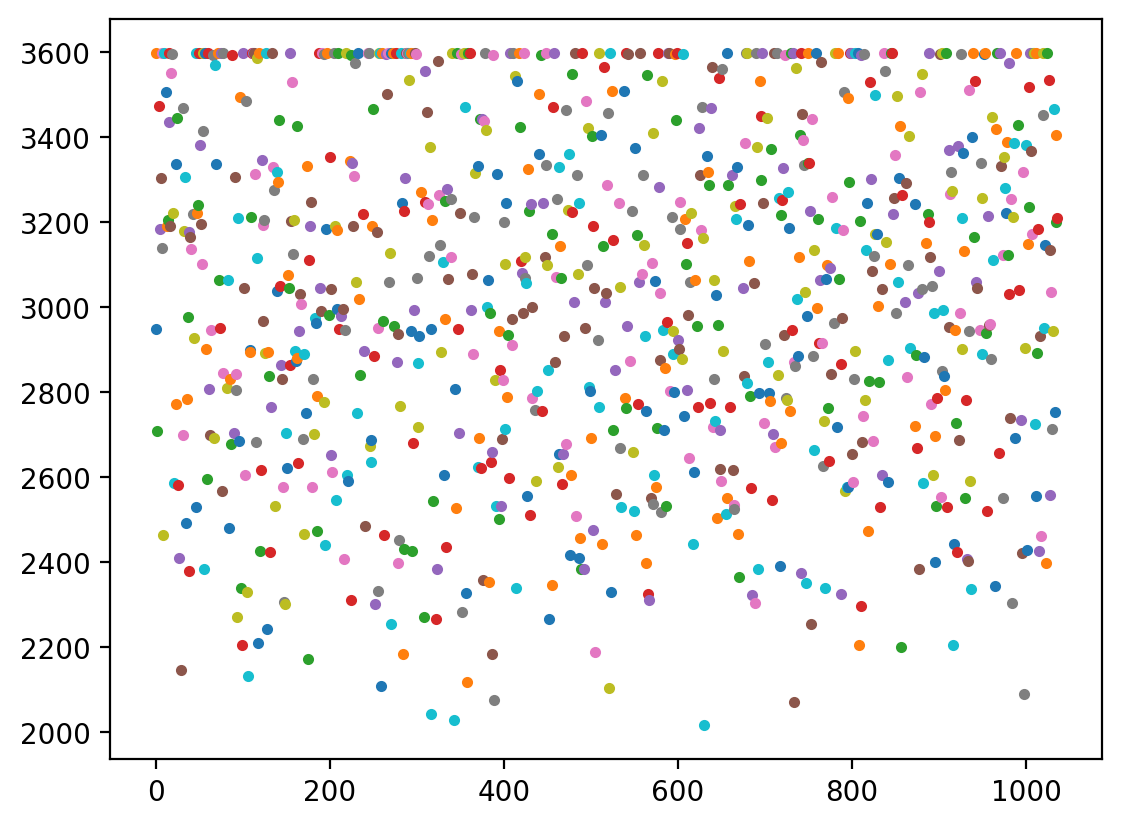

In [10]:
for year in range(2001, 2002): # 2021
    files = np.array(glob(join(vol, str(year), f'sgpsondewnpnC1.b1.*.cdf')))
    is_valid = np.ones(files.size, dtype=bool)
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        if valid_raob(xar):
            plt.plot(i, xar.pres.values.size, '.')
        else:
            is_valid[i] = False
        xar.close()
    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
    print(f'{year}: {np.where(is_valid == True)[0].size}/{files.size} are valid')

In [29]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = preprocess.interpolate_profile(xar.pres.values, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(xar.tdry.values, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(xar.dp.values, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
    fp.value += 1
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

FloatProgress(value=0.0, max=27209.0)

time: 692.739, avg: 0.025 seconds
: 24589/27209 are valid


In [31]:
# np.save('/s/chopin/l/grad/stock/data/soundings/raobs/profiles-4000.npy', profiles)

In [6]:
profiles = np.load(vol + '../profiles.npy')

In [7]:
profiles.shape

(24589, 3, 2000)

## Fully Connected NN

In [19]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, input_dims, :]
Xtrain = Xtrain.reshape((-1, Xtrain[0,:].size))
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = Xtest[:, input_dims, :]
Xtest = Xtest.reshape((-1, Xtest[0,:].size))
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 6000), (19671, 2000), (4918, 6000), (4918, 2000))

In [28]:
# 176 s
nnet = nn.NeuralNetwork(Xtrain.shape[1], [512, 256, 128, 256, 512], Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 64, method='adam', verbose=True, 
           learning_rate=0.005, validation=[Xtest, Ttest])

epoch: 0, loss: 0.21868
epoch: 5, loss: 0.08301
epoch: 10, loss: 0.07301
epoch: 15, loss: 0.06841
epoch: 20, loss: 0.06474
epoch: 24, loss: 0.06029
finished!


NeuralNetwork(6000, [512, 256, 128, 256, 512], 2000)
  Final objective value is 0.06029 in 117.1774 seconds.

In [56]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024 

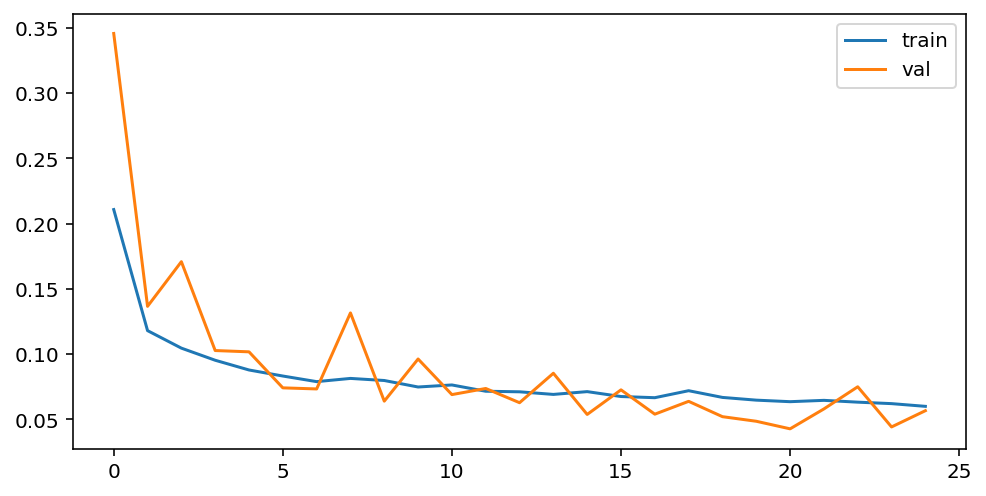

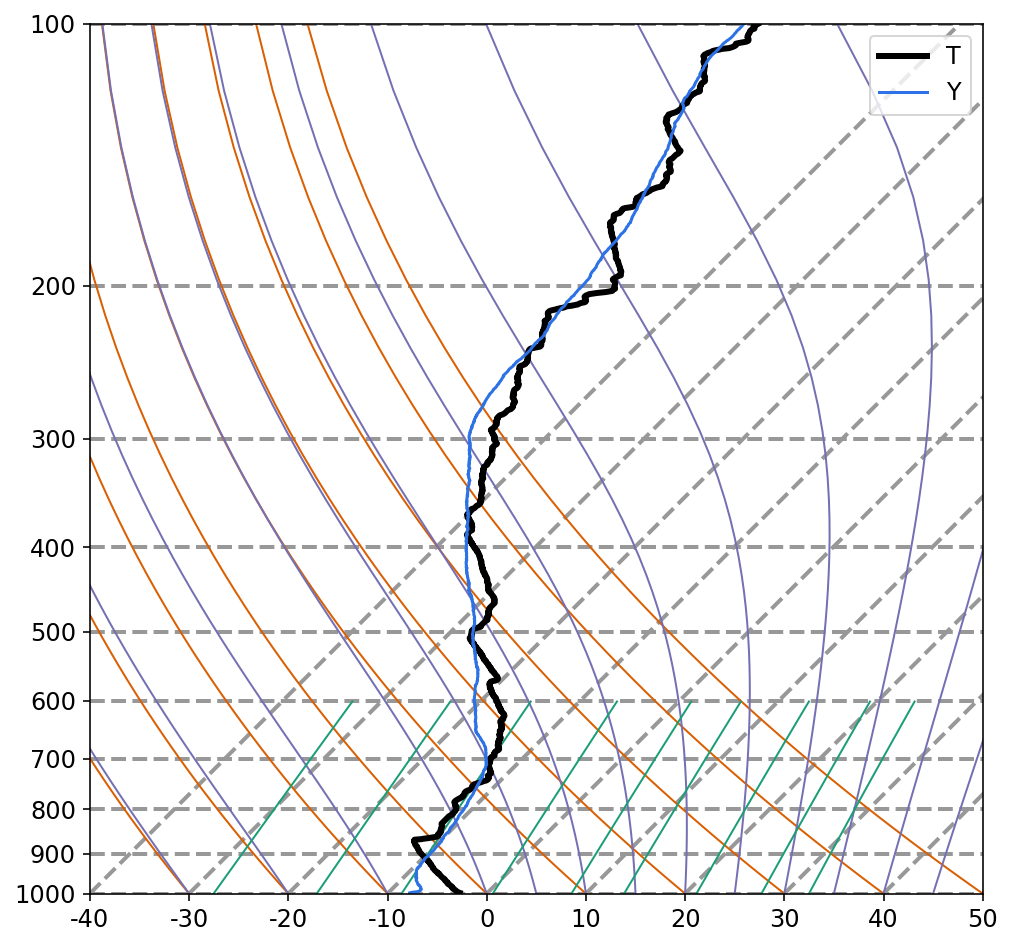

In [71]:
plot_results(nnet, Xtest, Ttest, index=0)

## Convolutional NN

In [11]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [13]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 15, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.63909
epoch: 5, loss: 0.00820
epoch: 10, loss: 0.00541
epoch: 14, loss: 0.00451
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00451 in 16.5112 seconds.

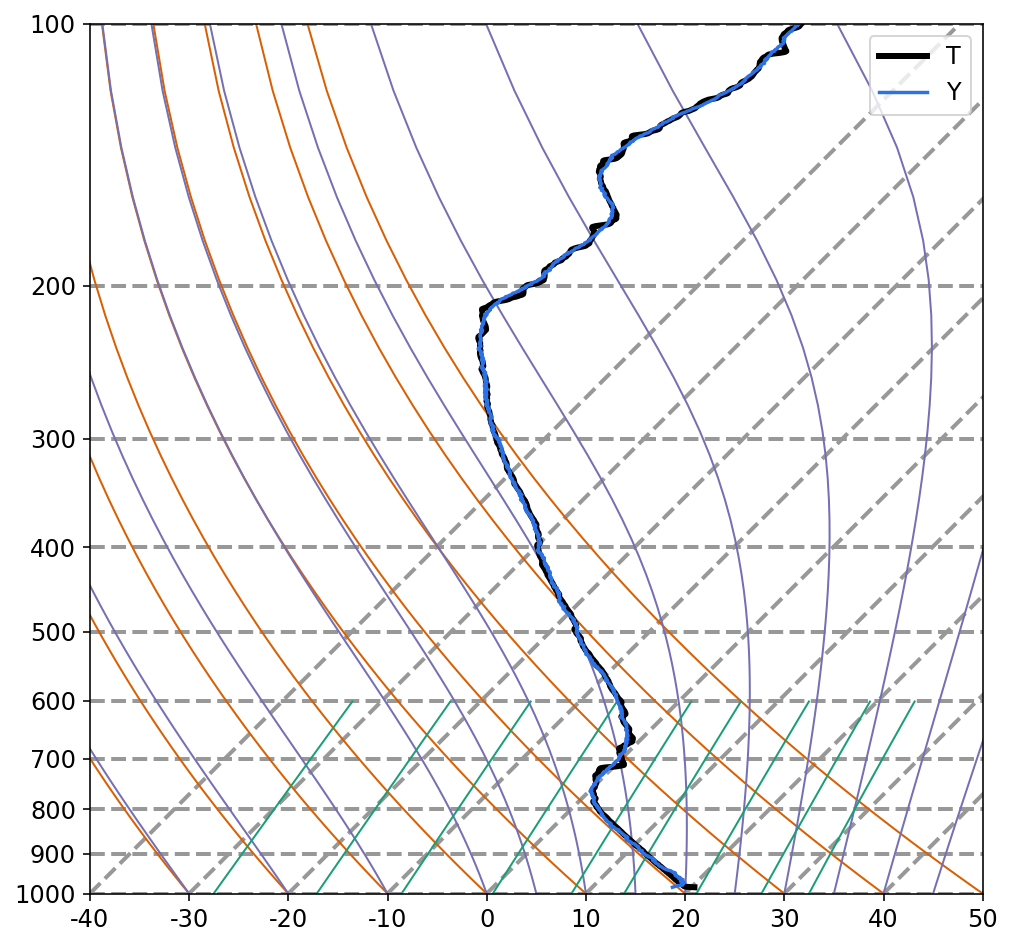

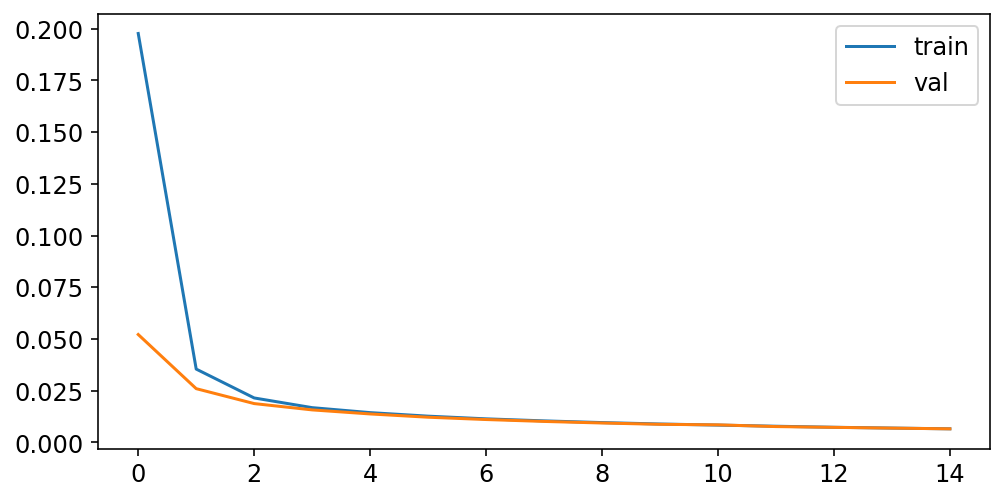

In [371]:
plot_results(nnet, Xtest, Ttest, index=22, loss=True)

In [372]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)

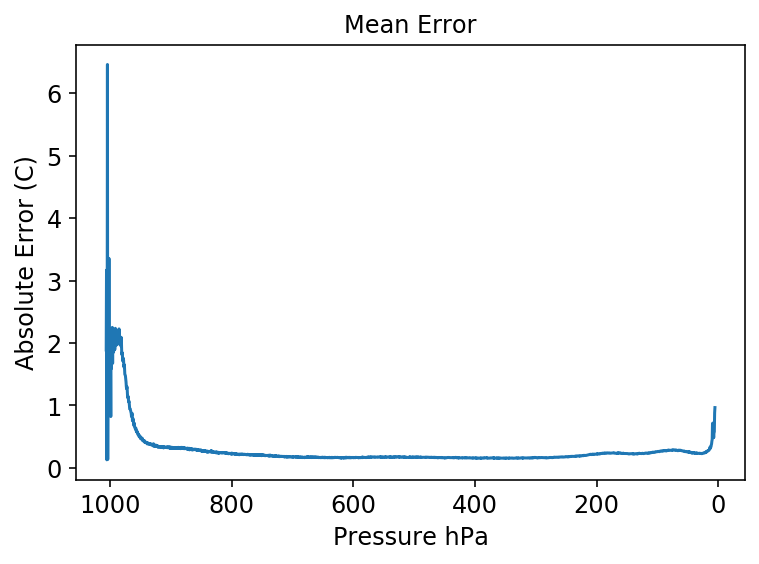

In [373]:
plt.plot(bins, mean_error)
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

FloatProgress(value=0.0, max=12.0)

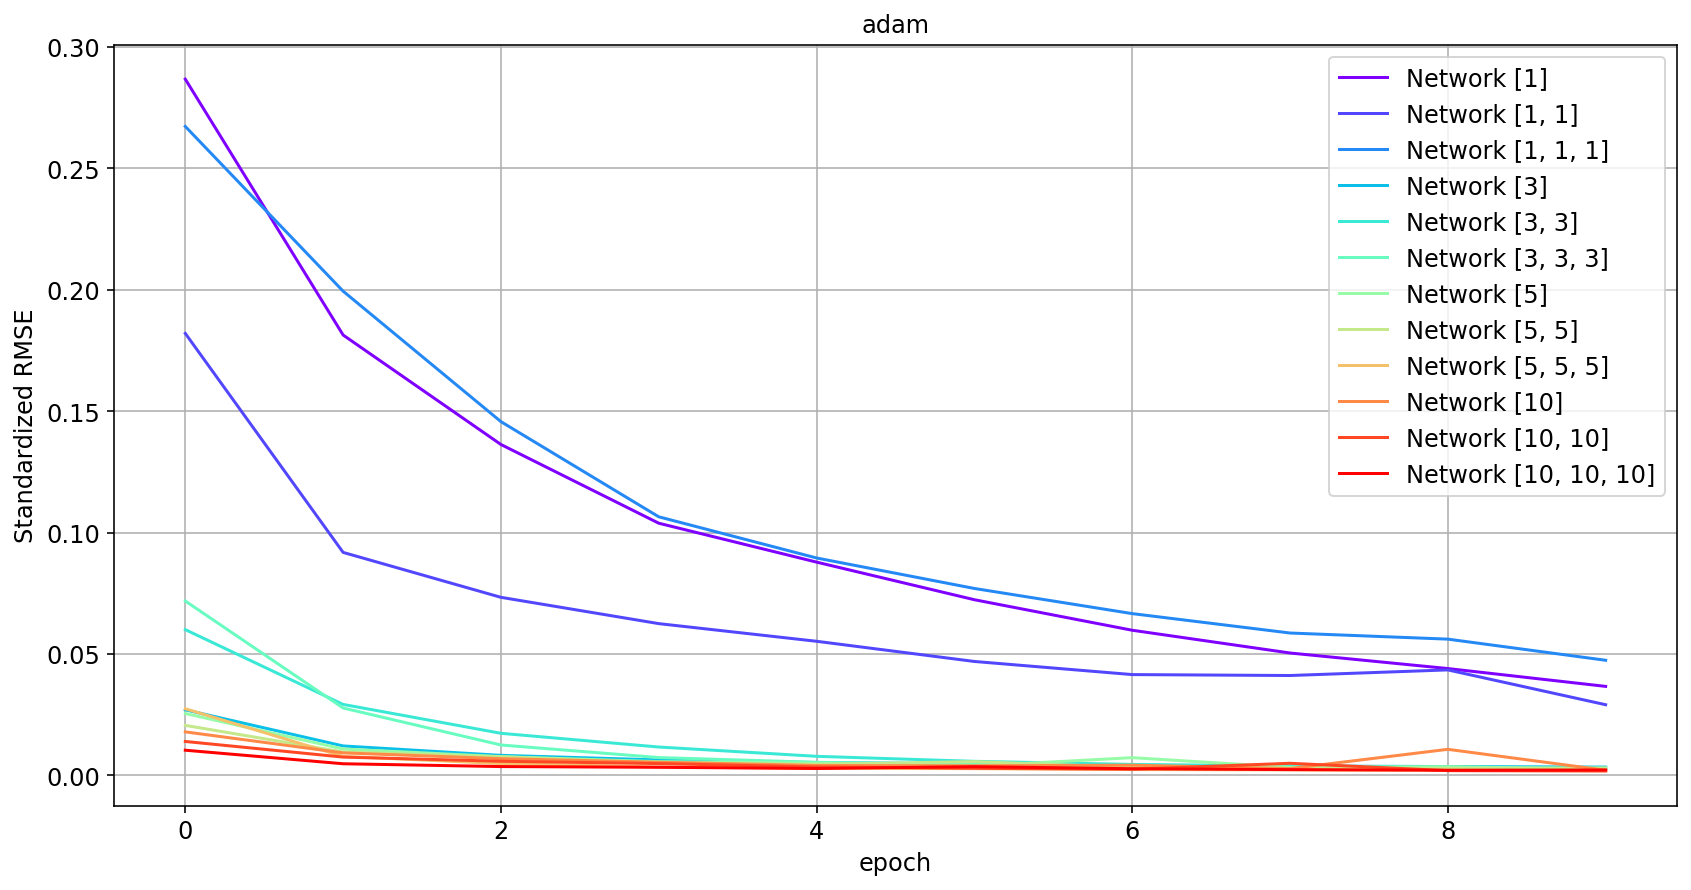

In [48]:
epochs = 10
batch_size = 128 #, 64
rho = 0.001
activation = 'relu'
depth = 3
units = [[nu] * nl for nu in [1, 3, 5, 10] for nl in range(1, depth + 1)] # 
ker_str = [[nu] * nl for nu in [(10, 1)] for nl in range(1, depth + 1)] # , (20, 1)
trials = len(units)

methods = ['adam']

f = FloatProgress(min=0, max=(trials * len(methods)))
display(f)

fig, axs = plt.subplots(len(methods), 1, figsize=(14, 7 * len(methods)))
for m, method in enumerate(methods):
    loss = []
    ax = axs if len(methods) == 1 else axs[m]
    for i in range(trials):
        n_units_in_conv_layers = units[i]
        
        kernels_size_and_stride = ker_str[len(n_units_in_conv_layers)-1]
        
        nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], n_units_in_conv_layers, 
                                             kernels_size_and_stride,
                                             Ttrain.shape[1], activation=activation, seed=1234)
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
                   learning_rate=rho, validation=[Xtest, Ttest])
        
        loss.append(nnet.history['val_loss'])
        f.value += 1
    
    color=iter(plt.cm.rainbow(np.linspace(0,1,trials)))

    for j, err in enumerate(loss):
        ax.plot(err, c=next(color), label='Network '+str(units[j]))

    ax.set_title(method)
    ax.set_xlabel('epoch'), plt.ylabel('Standardized RMSE')
    ax.legend(); ax.grid(True);

plt.show()

In [54]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 10)          310       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 10)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 10)          1010      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 10)           1010      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 10)           0     

## Convolutional AutoEncoder

In [166]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [178]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [32, 32, 32, 32], [(10, 1)]*4,
                                   Ttrain.shape[1], activation='relu',
                                   n_hidden_dims=500, seed=1234)

nnet.train(Xtrain, Ttrain, 20, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.10294
epoch: 5, loss: 0.00955
epoch: 10, loss: 0.00377
epoch: 15, loss: 0.00509
epoch: 19, loss: 0.00311
finished!


ConvolutionalAutoEncoder((2000, 3), [32, 32, 32, 32], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00311 in 149.6045 seconds.

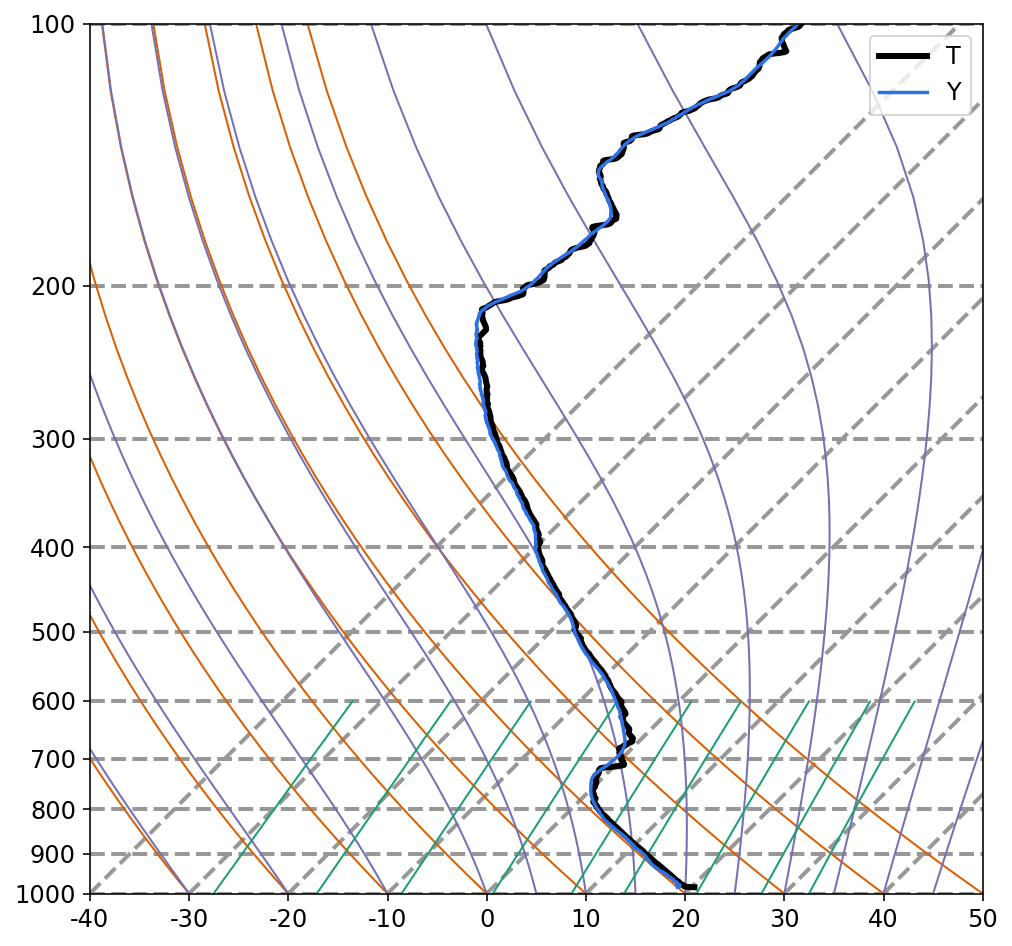

In [179]:
plot_results(nnet, Xtest, Ttest, index=22, loss=False)

0.2853031178763819


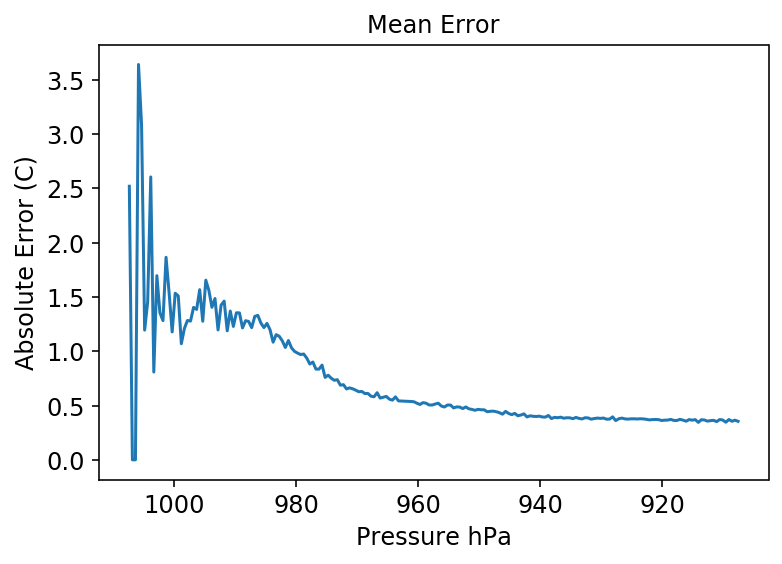

In [180]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
print(mean_error.mean())

plt.plot(bins[-200:], mean_error[-200:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

In [154]:
epochs = 20
batch_size = 128
rho = 0.001
activation = 'relu'
method = 'adam'
units = [4, 4, 8, 8]
ker_str = [(5, 1)]*4
hidden_dims_l = [10, 100, 500, 1000, 2000]

trials = len(hidden_dims_l)

rmse = []
bin_mean = []
loss = []

f = FloatProgress(min=0, max=(trials))
display(f)

for hidden_dims in hidden_dims_l:
    
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], units, ker_str,
                                       Ttrain.shape[1], activation=activation,
                                       n_hidden_dims=hidden_dims, seed=1234)
    
    nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
               learning_rate=rho, validation=[Xtest, Ttest])

    loss.append(nnet.history['val_loss'])
    rmse.append(ml.rmse(nnet.use(Xtest), Ttest))
    mean_error, _ = mean_pressure_errors(nnet, Xtest, Ttest)
    bin_mean.append(mean_error.mean())
    f.value += 1

FloatProgress(value=0.0, max=5.0)

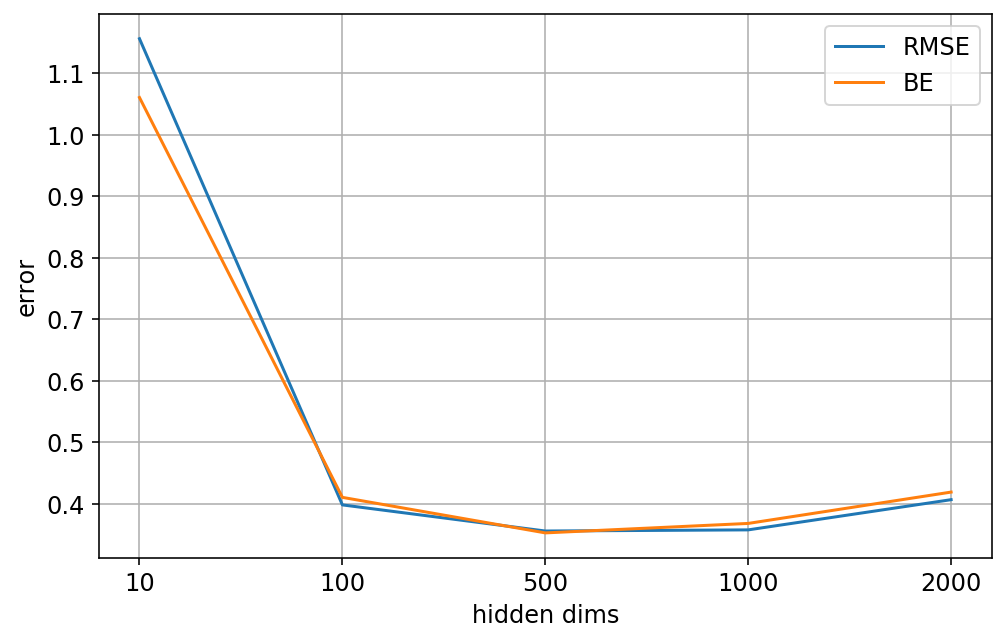

In [164]:
fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(rmse, label='RMSE')
ax.plot(bin_mean, label='BE')

ax.set_xticks(range(len(hidden_dims_l)))
ax.set_xticklabels(hidden_dims_l)

ax.set_xlabel('hidden dims'), ax.set_ylabel('error')
ax.legend(); ax.grid(True);

plt.show()

In [165]:
epochs = [10, 20, 30]
batch_size = 128
rho = 0.001
activation = 'relu'
method = 'adam'
units = [4, 4, 8, 8]
ker_str = [(5, 1)]*4
hidden_dims_l = 500

trials = len(epochs)

rmse = []
bin_mean = []
loss = []

f = FloatProgress(min=0, max=(trials))
display(f)

for epoch in epochs:
    
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], units, ker_str,
                                       Ttrain.shape[1], activation=activation,
                                       n_hidden_dims=500, seed=1234)
    
    nnet.train(Xtrain, Ttrain, epoch, batch_size, method=method, verbose=False, 
               learning_rate=rho, validation=[Xtest, Ttest])

    loss.append(nnet.history['val_loss'])
    rmse.append(ml.rmse(nnet.use(Xtest), Ttest))
    mean_error, _ = mean_pressure_errors(nnet, Xtest, Ttest)
    bin_mean.append(mean_error.mean())
    f.value += 1

FloatProgress(value=0.0, max=3.0)

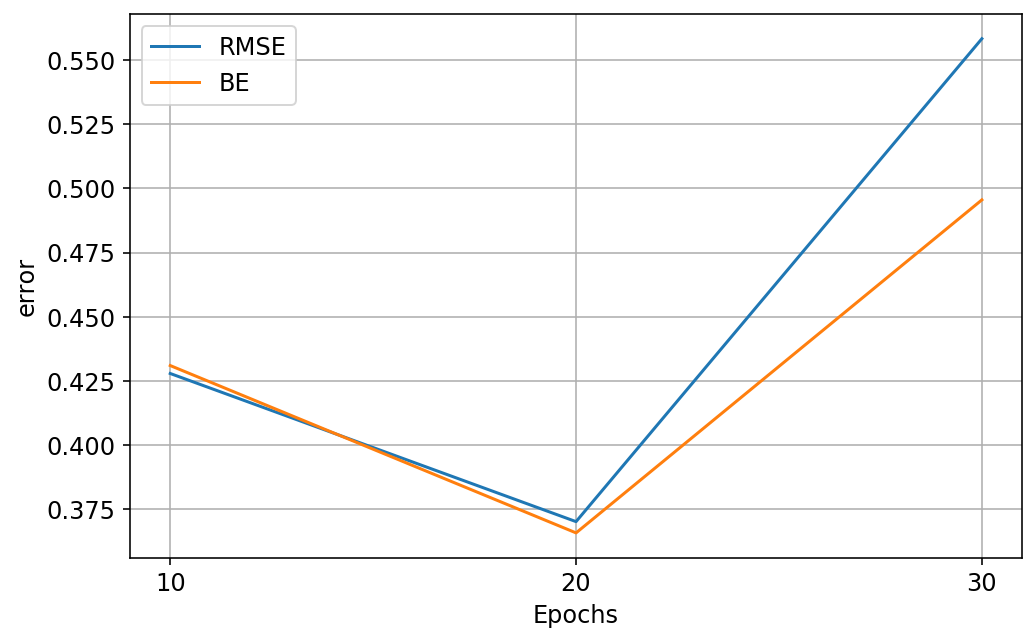

In [167]:
fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(rmse, label='RMSE')
ax.plot(bin_mean, label='BE')

ax.set_xticks(range(len(epochs)))
ax.set_xticklabels(epochs)

ax.set_xlabel('Epochs'), ax.set_ylabel('error')
ax.legend(); ax.grid(True);

plt.show()

## Operational

In [77]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      profiles:  1.1 GiB
                         files: 10.9 MiB
                      is_valid: 26.7 KiB
                 FloatProgress:  1.0 KiB
                           _i8:  926.0 B
                          _i24:  815.0 B
                          _i27:  810.0 B
                          _i29:  807.0 B
                          _i30:  807.0 B
                          _i32:  798.0 B


## Density

In [142]:
files = np.array(glob(join(vol, '2001/sgpsondewnpnC1.b1.*.cdf')))

pressures = np.array([])

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        pressures = np.append(pressures, xar.pres.values)    
    xar.close()    
e = time.time() - s

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

time: 11.227, avg: 0.011 seconds


In [143]:
pressures.shape

(2647636,)

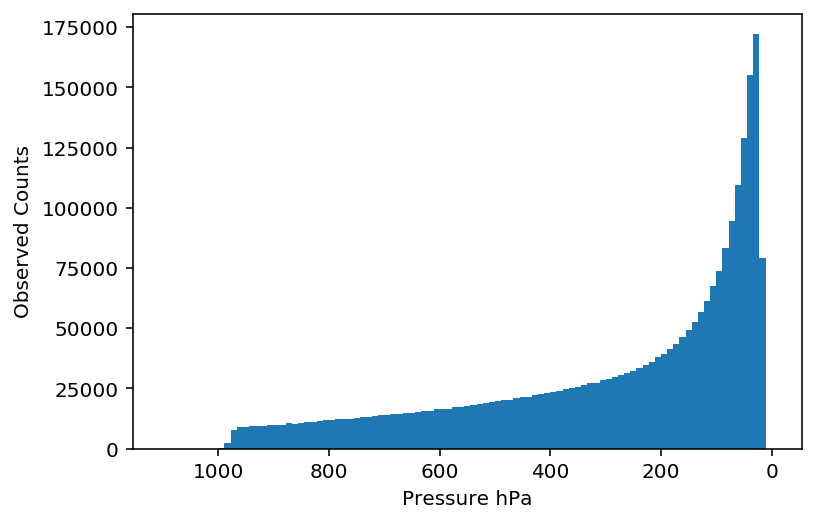

In [154]:
plt.hist(pressures, bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');

In [161]:
Xtrain[:,:,PRESSURE].ravel().shape

(39342000,)

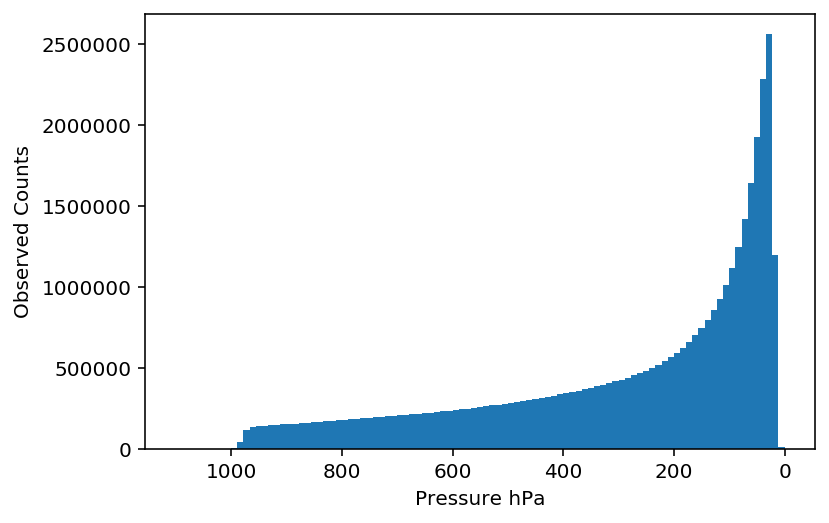

In [160]:
plt.hist(Xtrain[:,:,PRESSURE].ravel(), bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');

## Improved Surface Predictions

1. Interpolate high pressure values - increase precision at lower altitudes
2. Apply more weight to high pressure values - modify loss function
3. Ground surface level measurements - include RTMA data to improve on surface RAOB data
4. Evaluate models that are trained at different levels - can the surface be modeled correctly without interference of higher altitudes 

### 1. Intropolation

In [ ]:
surface = int(round(np.mean(np.argmin(np.abs(Xtrain[:, :, PRESSURE] - 900), axis=1))))
SURFACE_IN_DIMS = 500

Xptrain = np.zeros((Xtrain.shape[0], Xtrain.shape[1] - surface + SURFACE_IN_DIMS, len(input_dims)))
for i in range(Xtrain.shape[0]):
    for dim in input_dims:
        Xptrain[i, :SURFACE_IN_DIMS, dim] = preprocess.interpolate_profile(
            Xtrain[i, :surface, dim], SURFACE_IN_DIMS)
        Xptrain[i, SURFACE_IN_DIMS:, dim] = Xtrain[i, surface:, dim]
        
Xptest = np.zeros((Xtest.shape[0], Xtest.shape[1] - surface + SURFACE_IN_DIMS, len(input_dims)))
for i in range(Xtest.shape[0]):
    for dim in input_dims:
        Xptest[i, :SURFACE_IN_DIMS, dim] = preprocess.interpolate_profile(
            Xtest[i, :surface, dim], SURFACE_IN_DIMS)
        Xptest[i, SURFACE_IN_DIMS:, dim] = Xtest[i, surface:, dim]

Profile on equal 5 ml distances

In [6]:
xar = xr.open_dataset(vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

In [15]:


def compute_pressure_intervals(p, interval=5):
    p_s = p[0]
    p_t = int(math.ceil(p[-1] / interval)) * interval
    return np.insert(np.arange(p_t, p_s, interval)[::-1], 0, p_s)

def interpolate_to_pressure_values(p, y, p_n):
    f = interpolate.interp1d(p, y)
    return f(p_n)

In [46]:
p_n = compute_pressure_intervals(p, interval=5)
t_n = interpolate_to_pressure_values(p, t, p_n)
td_n = interpolate_to_pressure_values(p, td, p_n)
# pressures, (p, t, td)
profile = np.concatenate((p_n.reshape(-1,1), t_n.reshape(-1,1), td_n.reshape(-1,1)))

In [ ]:
profiles = []

Check top EL and find how many soundings make it to this level.

In [4]:
profiles = np.load(vol + '../profiles.npy')

In [5]:
profiles.shape

(24589, 3, 2000)

In [52]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [85]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

profiles = []

max_profile_len = 0

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = xar.pres.values
        t = xar.tdry.values
        td = xar.dp.values
        p_n = compute_pressure_intervals(p, interval=5)
        t_n = interpolate_to_pressure_values(p, t, p_n)
        td_n = interpolate_to_pressure_values(p, td, p_n)
        if len(p_n) > max_profile_len:
            max_profile_len = len(p_n)
        profile = np.concatenate((p_n.reshape(-1,1), t_n.reshape(-1,1), td_n.reshape(-1,1)), axis=1)
        profiles.append(profile)        
    xar.close()
    fp.value += 1
e = time.time() - s

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

FloatProgress(value=0.0, max=27209.0)

time: 718.131, avg: 0.026 seconds


In [86]:
max_profile_len

200

In [82]:
profile = profiles[0]
profile = np.pad(profile, ((0, max_profile_len - len(profile)), (0,0)), 'constant', constant_values=(0,-9999.))

In [87]:
profiles_padded = np.zeros((len(profiles), max_profile_len, 3))
for i in range(len(profiles)):
    profiles_padded[i] = np.pad(profiles[i], ((0, max_profile_len - len(profiles[i])), (0,0)), 
                                'constant', constant_values=(0,-9999.))

In [92]:
profiles_padded.shape

(25460, 200, 3)

In [93]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles_padded, profiles_padded, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]

In [94]:
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((20368, 200, 3), (20368, 200), (5092, 200, 3), (5092, 200))

In [103]:
nnet = nn.ConvolutionalAutoEncoderMask(Xtrain.shape[1:], [3]*2, [(3, 1)]*3,
                                       Ttrain.shape[1], activation='relu', n_hidden_dims=100, seed=1234)

nnet.train(Xtrain, Ttrain, 10, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

AttributeError: 'Masking' object has no attribute 'shape'

In [6]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

is_valid = np.ones(files.size, dtype=bool)
els = np.zeros(files.size)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        sounding_dict = dict()
        sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.pres.values
        sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.tdry.values
        sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.dp.values
        try:
            el_p, el_t = radiosonde_products.el(sounding_dict)
            els[i] = el_p
        except:
            is_valid[i] = False
            pass
    else:
        is_valid[i] = False
    xar.close()    
    fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

FloatProgress(value=0.0, max=27209.0)

/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: divide by zero encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in multiply
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: divide by zero encountered in true_divide
  intersect_y = ((intersect_x - x0) /

time: 3834.839, avg: 0.141 seconds


compute mean top of atm pressure level as top boundry.

In [23]:
valid_els = els[is_valid]
valid_els = valid_els[~np.isnan(valid_els)]
valid_els.shape, valid_els.mean(), valid_els.std(), valid_els.max(), valid_els.min()

((11529,),
 386.3695026281408,
 269.25075421545586,
 991.1999957655736,
 71.79910689772912)

In [147]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

profiles = []
valid_profiles = []

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        profile = np.concatenate((xar.pres.values.reshape(-1,1),
                                  xar.tdry.values.reshape(-1,1),
                                  xar.dp.values.reshape(-1,1)), axis=1)
        profiles.append(profile)
        valid_profiles.append(f)
    xar.close()
    fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

FloatProgress(value=0.0, max=27209.0)

time: 386.570, avg: 0.014 seconds


In [150]:
# with open(vol + '../valid_file_names.txt', 'w') as f:
#     for item in valid_profiles:
#         f.write("%s\n" % item)

In [148]:
top_boundary = 50

In [149]:
valid_profile_boundries = []
for i, profile in enumerate(profiles):
    if profile[:, 0][-1] <= top_boundary: # just above the min EL
        valid_profile_boundries.append(i)
print(f'files, total: {len(files)}, valid: {len(profiles)}, p <= 50 mb: {len(valid_profile_boundries)}')

files, total: 27209, valid: 25460, p <= 50 mb: 23517


In [151]:
profiles = np.array(profiles)

In [152]:
profiles = profiles[valid_profile_boundries]

In [281]:
def interpolate_to_sigma_intervals(sigma, y, sigma_n):
    f = interpolate.interp1d(sigma, y)
    return f(sigma_n)

def presure_to_sigma(p):
    """𝜎 = (𝑝−𝑝𝑇)/(𝑝𝑆−𝑝𝑇)"""
    return (p - p[-1])/(p[0] - p[-1])

def sigma_to_pressure(sigma, p):
    """𝑝 = 𝑝𝑇 + 𝜎(𝑝𝑆−𝑝𝑇)"""
    return p[-1] + sigma*(p[0] - p[-1])

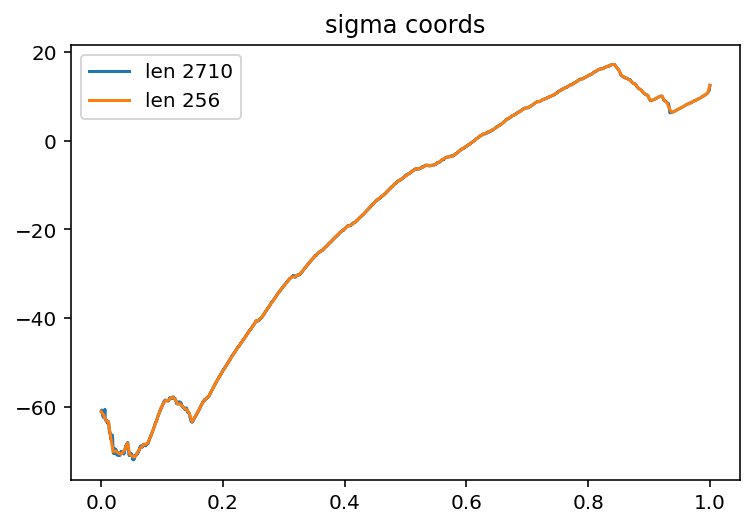

In [154]:
profile = profiles[0]

top_index = np.argmin(np.abs(profile[:, 0] - top_boundary))

p = profile[:top_index + 1, 0]
t = profile[:top_index + 1, 1]
td = profile[:top_index + 1, 2]
sigma = presure_to_sigma(p)

sigma_interval = np.linspace(0, 1, 256)
t_n = interpolate_to_sigma_intervals(sigma, t, sigma_interval)

plt.plot(sigma, t, label=f'len {len(t)}')
plt.plot(sigma_interval, t_n, label=f'len {len(t_n)}')
plt.title('sigma coords'); plt.legend();

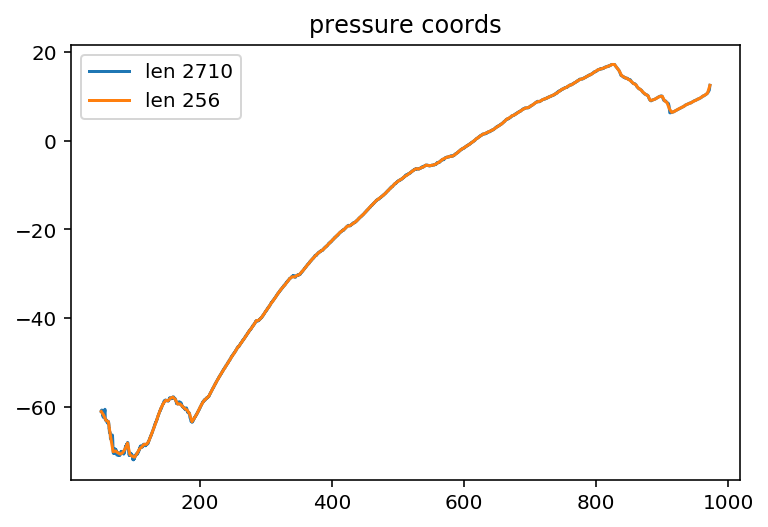

In [155]:
ps = sigma_to_pressure(sigma_interval, p)
plt.plot(p, t, label=f'len {len(t)}')
plt.plot(ps, t_n, label=f'len {len(t_n)}')
plt.title('pressure coords'); plt.legend();

In [108]:
profiles[0].shape

(3574, 3)

In [141]:
profiles[7052]

array([[ 5. ,  1.4, -4.5]], dtype=float32)

In [156]:
sigma_dims = 256
# Samples, Sigma Dims, (Sigma, Temperature, Dewpoint)
sigma_profiles = np.zeros((len(profiles), sigma_dims, 3))
# Samples, (Pressure Surface, Pressure Top)
pressure_metadata = np.zeros((len(profiles), 2))

for i, profile in enumerate(profiles):

    top_index = np.argmin(np.abs(profile[:, 0] - top_boundary))
    
    p = profile[:top_index + 1, 0]
    t = profile[:top_index + 1, 1]
    td = profile[:top_index + 1, 2]

    sigma = presure_to_sigma(p)
    sigma_interval = np.linspace(0, 1, sigma_dims)
    
    t_n = interpolate_to_sigma_intervals(sigma, t, sigma_interval)
    td_n = interpolate_to_sigma_intervals(sigma, td, sigma_interval)
    sigma_profiles[i] = np.concatenate((sigma_interval.reshape(-1,1), 
                                        t_n.reshape(-1,1), 
                                        td_n.reshape(-1,1)), axis=1)
    pressure_metadata[i] = [p[0], p[-1]]

In [238]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(sigma_profiles, sigma_profiles, (0.8,0.2), shuffle=False)
Xtrain_meta, Ttrain_meta, Xtest_meta, Ttest_meta = ml.partition(pressure_metadata, pressure_metadata, (0.8,0.2), shuffle=False)

input_dims = [SIGMA, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]

In [256]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(10, 1)]*4,
                                   Ttrain.shape[1], activation='relu',
                                   n_hidden_dims=100, seed=1234)

nnet.train(Xtrain, Ttrain, 1, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.47141


ConvolutionalAutoEncoder((256, 2), [4, 4, 8, 8], [(10, 1), (10, 1), (10, 1), (10, 1)], 256)
  Final objective value is 0.47141 in 3.3782 seconds.

In [252]:
def covert_X_to_pressure(X, X_meta):
    """Assumed to have shape (Samples, Sigma Dims, (Sigma, Temperature, Dewpoint))"""
    X_pressure = np.zeros(X.shape)
    for i in range(len(X)):
        X_pressure[i, :, PRESSURE] = sigma_to_pressure(X[i, :, SIGMA], X_meta[i])
        X_pressure[i, :, TEMPERATURE] = X[i, :, TEMPERATURE]
        X_pressure[i, :, DEWPOINT] = X[i, :, DEWPOINT]
    return X_pressure

In [253]:
Xtrain_pressure = covert_X_to_pressure(Xtrain, Xtrain_meta)

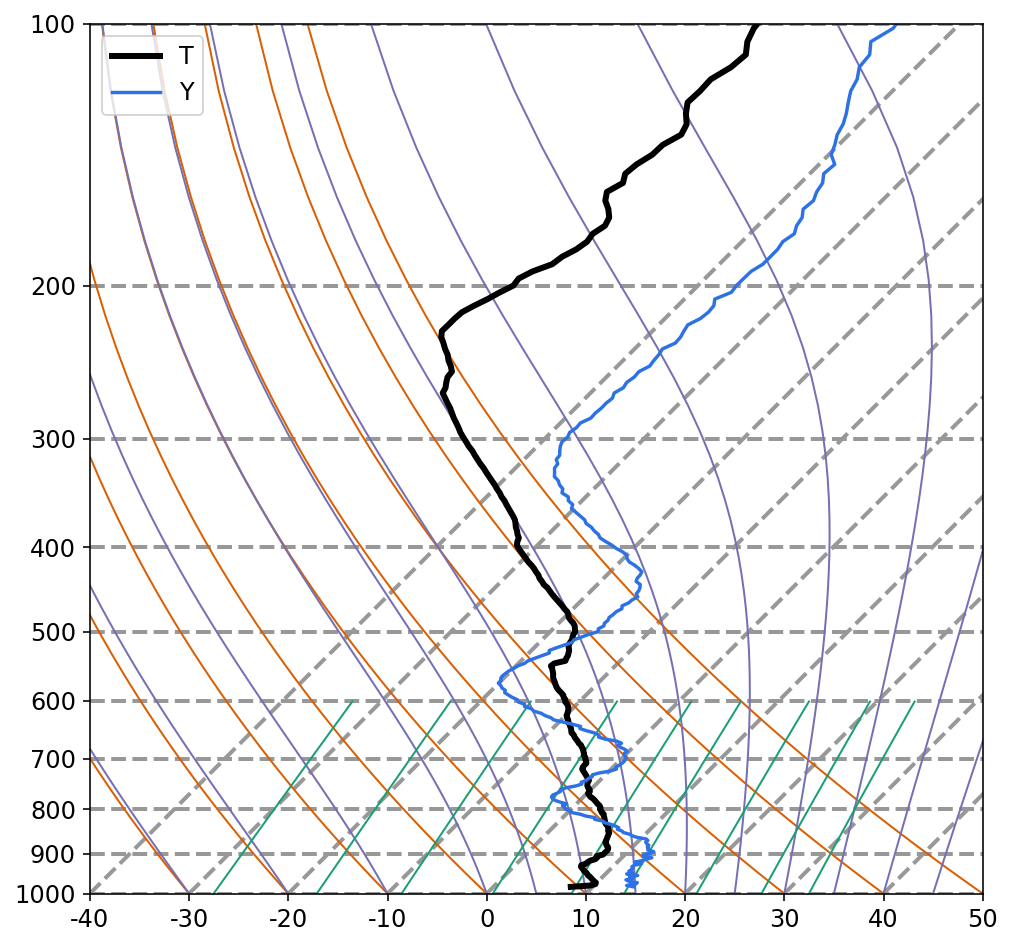

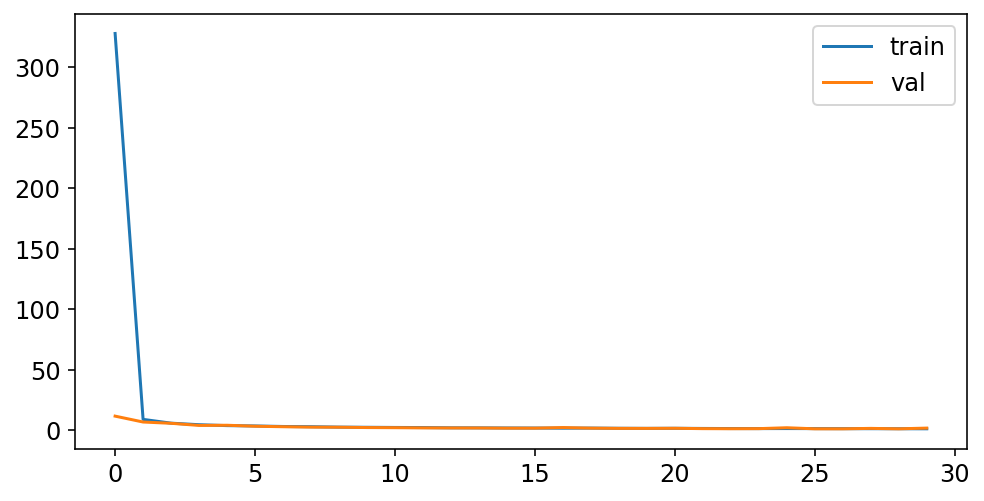

In [254]:
plot_results(nnet, Xtrain_pressure, Ttrain, 4, loss=True)

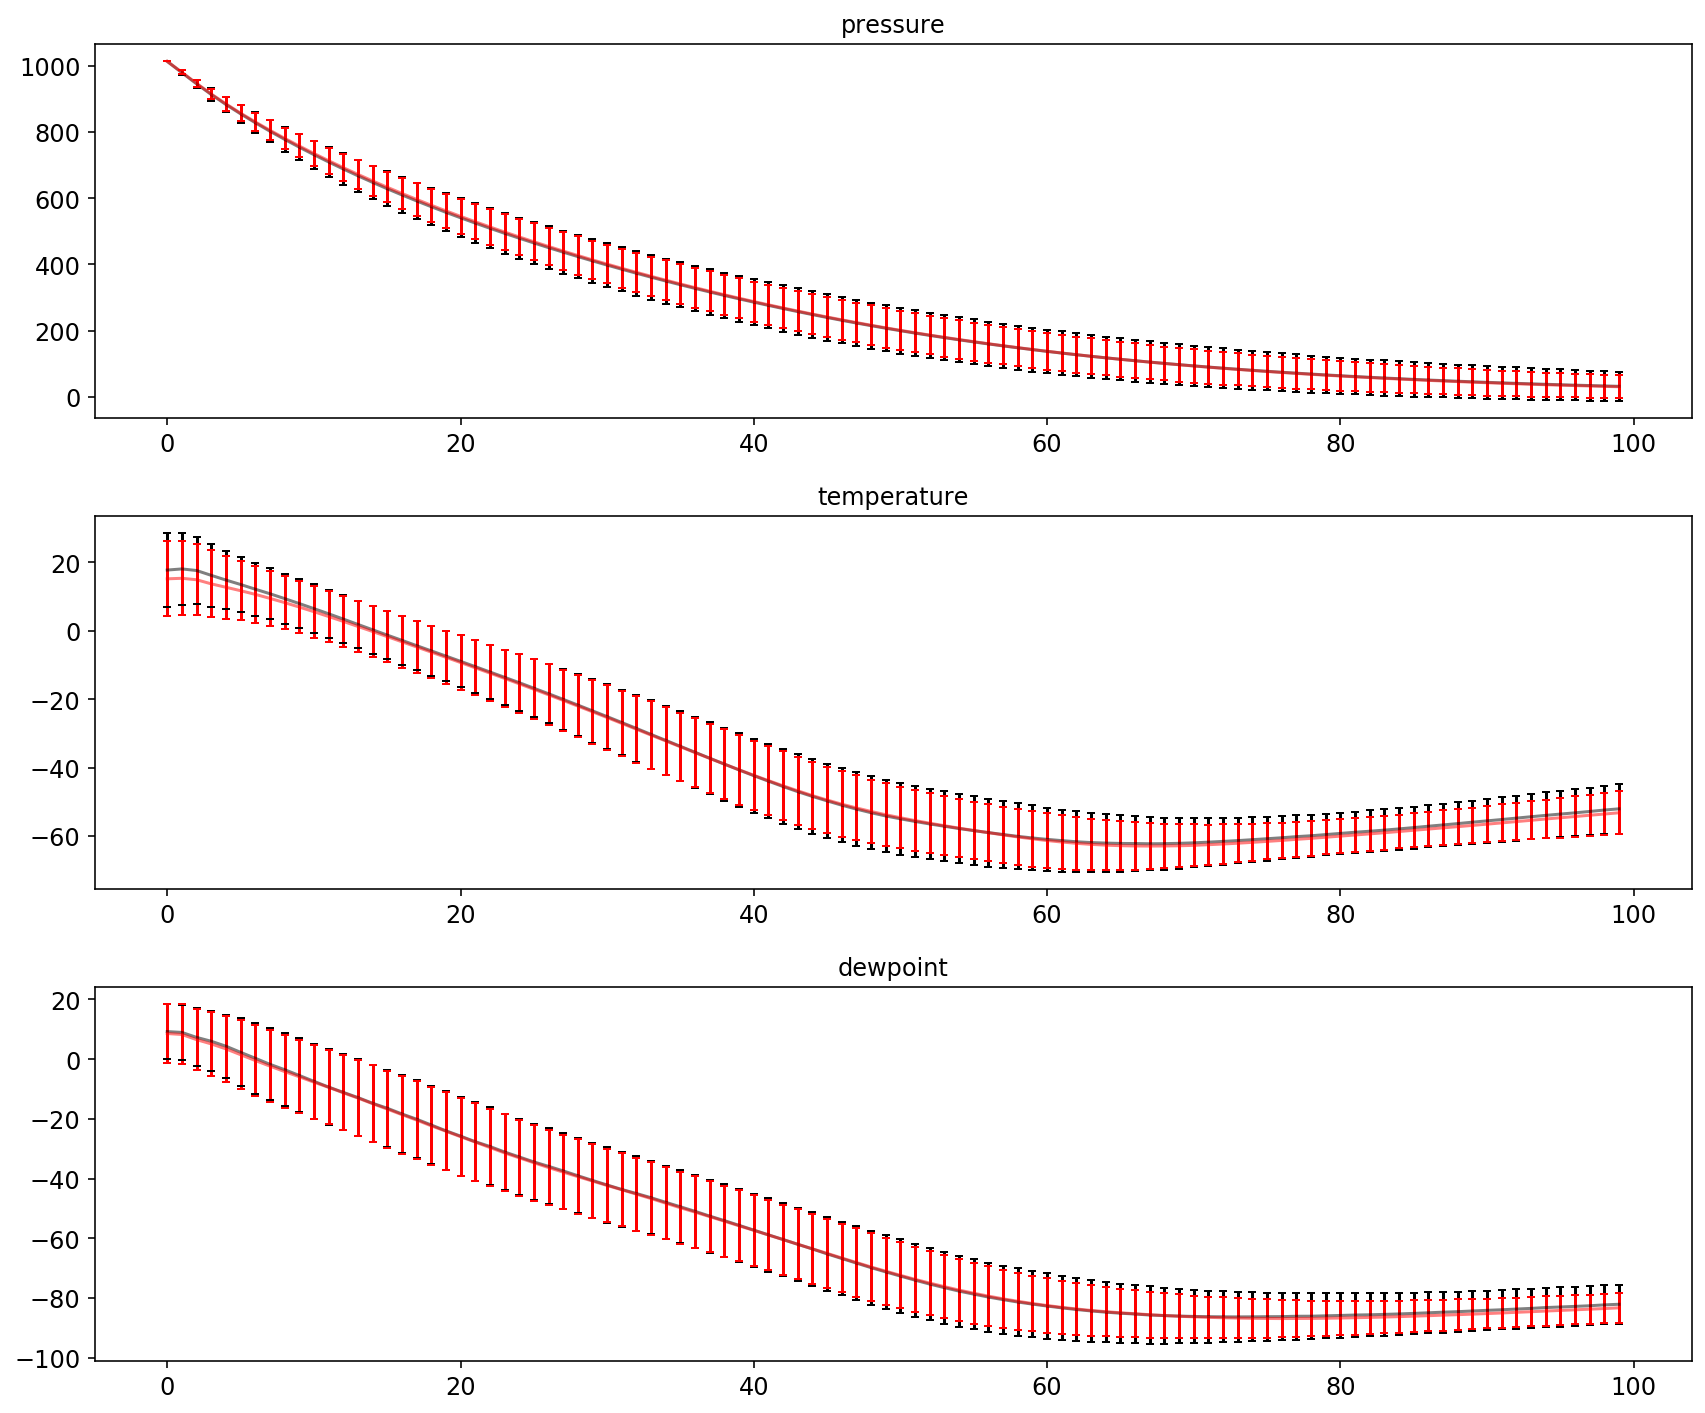

In [308]:
fig, axs = plt.subplots(len(input_dims), figsize=(12, 10))
axs = axs.ravel()
labels = ['pressure', 'temperature', 'dewpoint']
for dim in input_dims:

    mu = np.mean(Xtest[:,:,dim], axis=0)[::20]
    std = np.std(Xtest[:,:,dim], axis=0)[::20]

    axs[dim].plot(mu, 'k', alpha=0.5)
    axs[dim].errorbar(np.arange(mu.shape[0]), mu, std, color='k', linestyle='None', capsize=2);

    mu = np.mean(Xtrain[:,:,dim], axis=0)[::20]
    std = np.std(Xtrain[:,:,dim], axis=0)[::20]

    axs[dim].plot(mu, 'r', alpha=0.5, label='train')
    axs[dim].errorbar(np.arange(mu.shape[0]), mu, std, color='r', linestyle='None', capsize=2);
    axs[dim].set_title(labels[dim])
fig.tight_layout();               

### 2. Weighted Loss

- tf.keras.losses.logcosh performed well

In [69]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

In [137]:
np.linspace(0, 3, 4)

array([0., 1., 2., 3.])

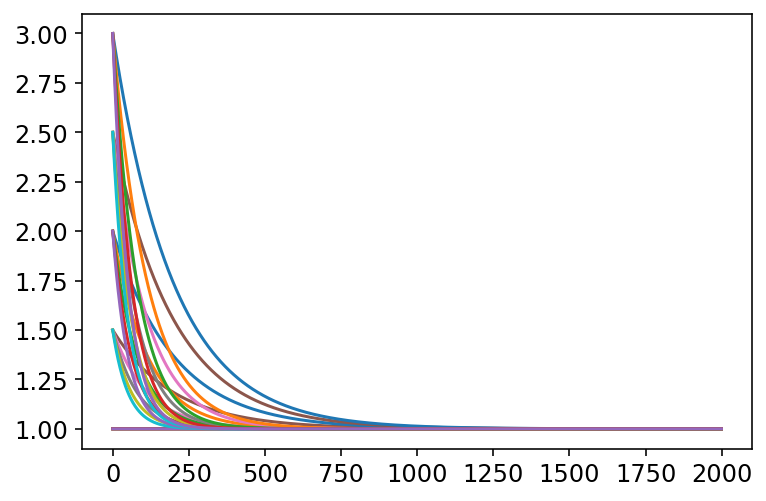

In [143]:
x = np.arange(2000)

for scale, lmda in itertools.product(np.linspace(0, 2, 5), np.linspace(0.005, 0.02, 5)):
    y = lambda x: scale * np.exp(-lmda * x) + 1
    plt.plot(y(x));

In [148]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]

In [149]:
def weighted_mean_squared_error(y_true, y_pred, scale, lmda):
    """exponential decay weighted MSE"""
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)

    x = np.arange(diff.shape[1])
    y = lambda x: scale * np.exp(-lmda * x) + 1
    diff *= y(x)

    return K.mean(diff, axis=-1)

In [150]:
loss_l = []
mean_bin_error_l = []
bin_error_l = []
scales = np.linspace(0, 2, 5)
lmdas = np.linspace(0.005, 0.02, 5)

f = FloatProgress(min=0, max=(len(scales) * len(lmdas)))
display(f)

for scale, lmda in itertools.product(scales, lmdas):
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(5, 1)]*4,
                                       Ttrain.shape[1], activation='relu',
                                       n_hidden_dims=500, seed=1234)
    
    nnet.train(Xtrain, Ttrain, 20, 128, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest], 
               loss_f=[lambda y_true,y_pred: weighted_mean_squared_error(y_true, y_pred, 
                                                                         scale=scale, lmda=lmda)])
    
    loss_l.append(nnet.history['val_loss'])
    
    mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
    mean_bin_error_l.append(mean_error)
    bin_error_l.append(bins)
    f.value += 1

FloatProgress(value=0.0, max=25.0)

#### y = lambda x: scale * np.exp(-.03 * x) + 1
new model with 500 h_dims and 

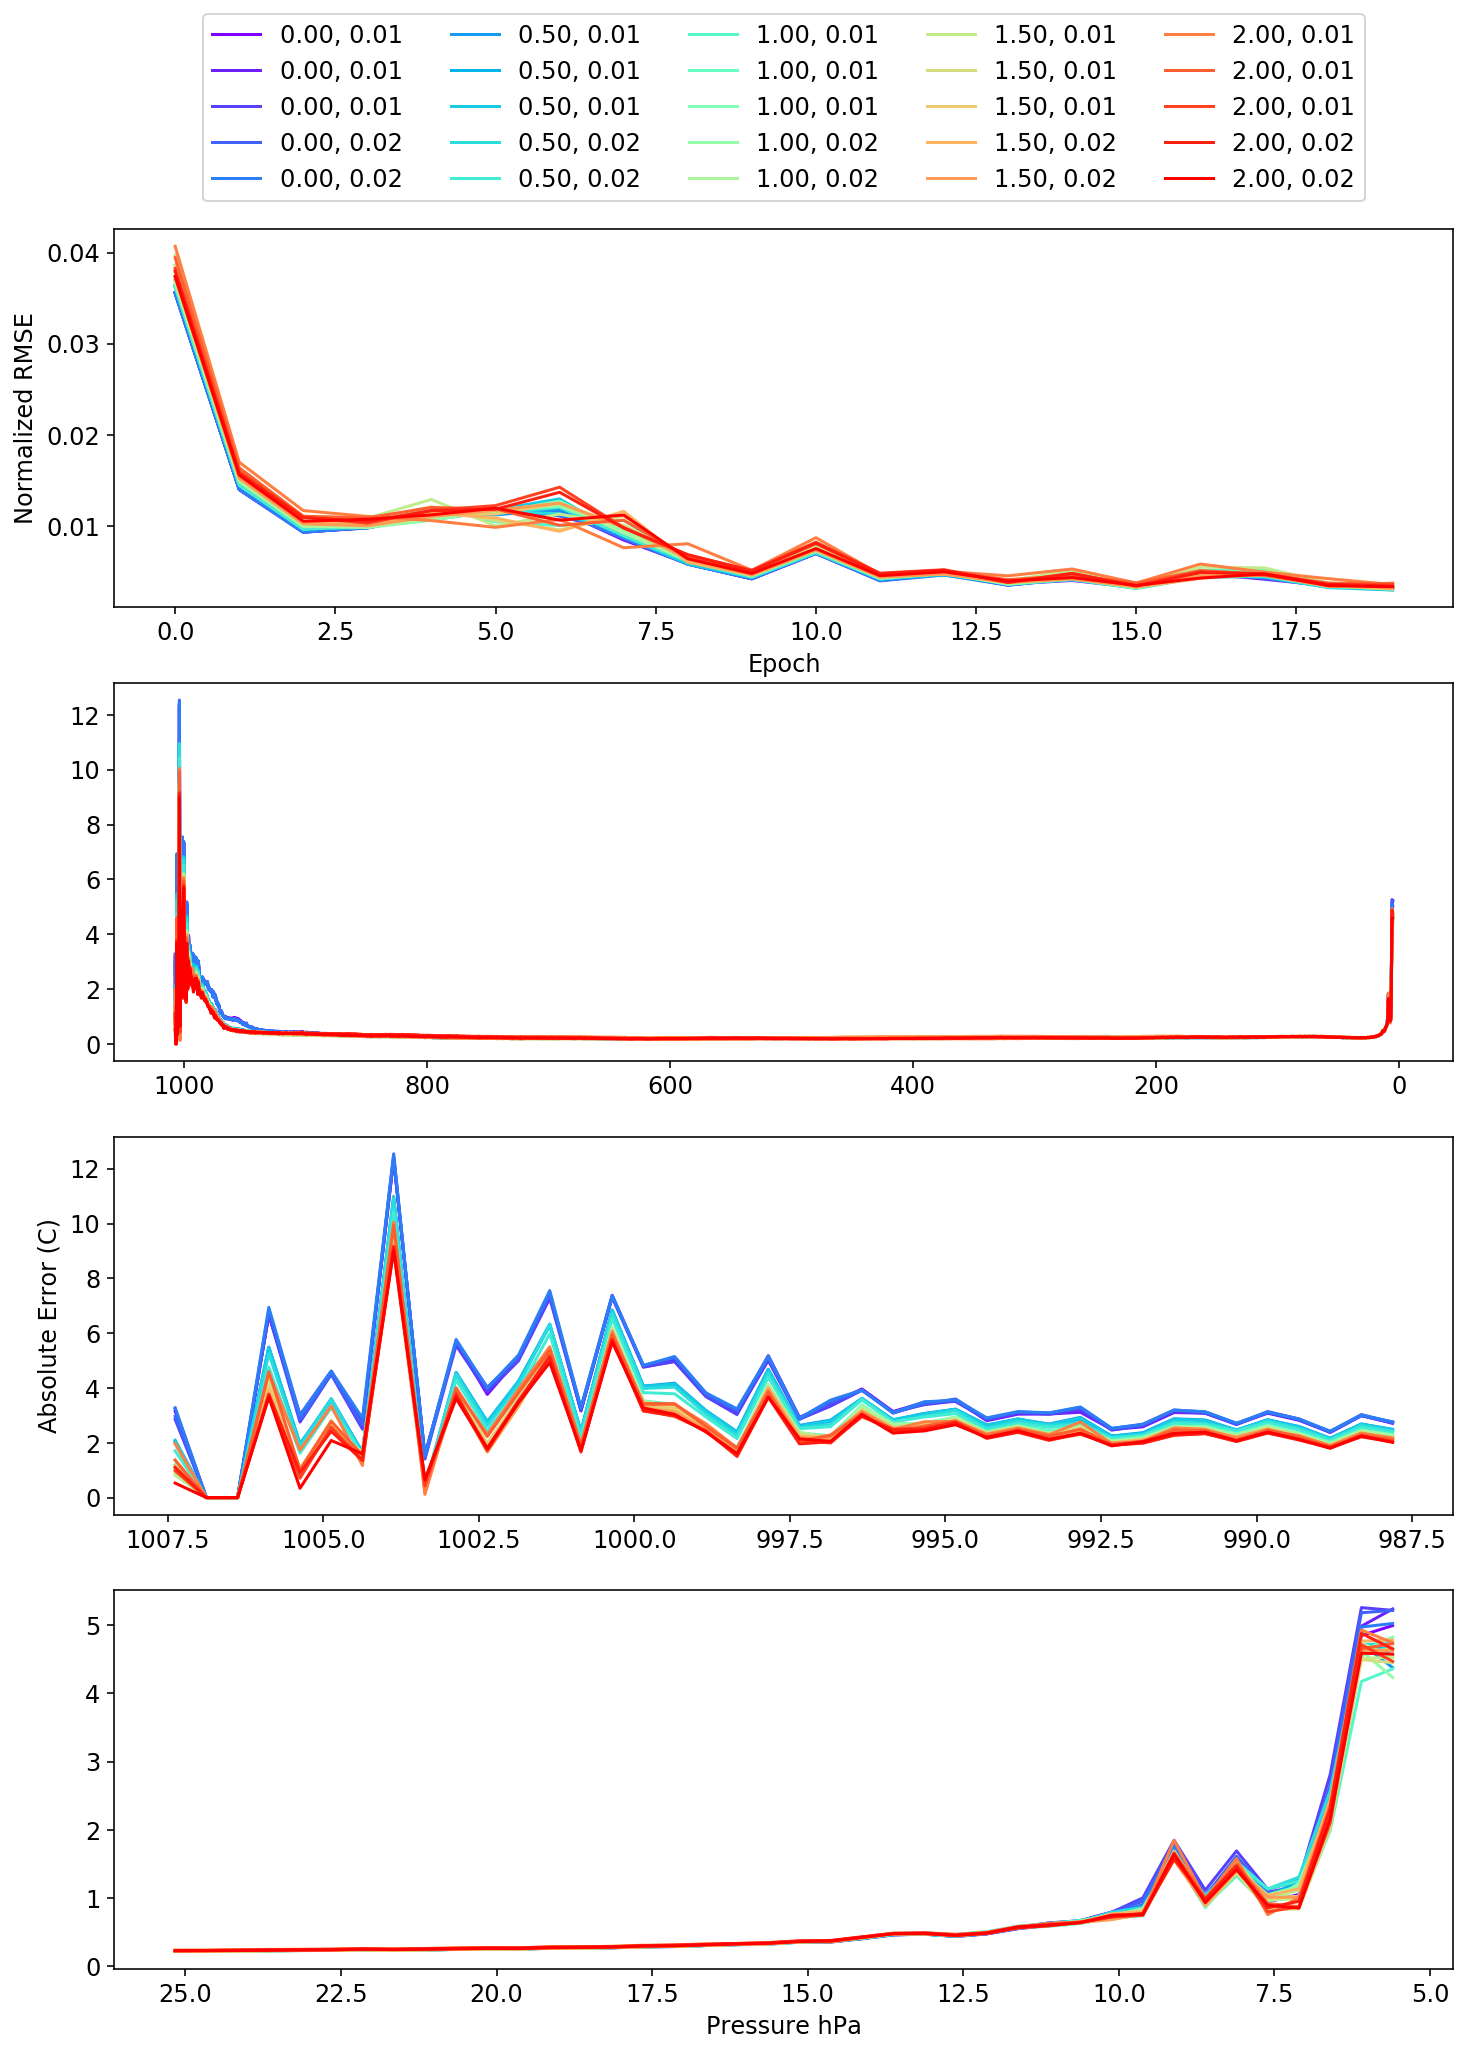

In [165]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16))
axs = axs.ravel()

color=iter(plt.cm.rainbow(np.linspace(0,1,len(scales) * len(lmdas))))

i = 0
for scale, lmda in itertools.product(scales, lmdas):
    c = next(color)
    axs[0].plot(loss_l[i], label=f'{scale:.2f}, {lmda:.2f}', color=c)
    axs[1].plot(bin_error_l[i], mean_bin_error_l[i], color=c)
    axs[2].plot(bin_error_l[i][-40:], mean_bin_error_l[i][-40:], color=c)
    axs[3].plot(bin_error_l[i][:40], mean_bin_error_l[i][:40], color=c)
    i += 1
    
axs[0].set_xlabel('Epoch');
axs[0].set_ylabel('Normalized RMSE')

for i in range(1, 4):
    axs[i].invert_xaxis()
axs[3].set_xlabel('Pressure hPa')
axs[2].set_ylabel('Absolute Error (C)');

axs.flatten()[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=5);

In [162]:
results = []
i = 0
for scale, lmda in itertools.product(scales, lmdas):
    results.append({'scale': f'{scale:.2f}', 'lambda': f'{lmda:.2f}', 'min_loss': np.min(loss_l[i]),
                   'mean_abs_error': mean_bin_error_l[i].mean(), 'std_abs_error': mean_bin_error_l[i].std(),
                   'min_abs_error': mean_bin_error_l[i].min(), 'max_abs_error': mean_bin_error_l[i].max()})
    i += 1
df = pd.DataFrame(results)
df

,scale,lambda,min_loss,mean_abs_error,std_abs_error,min_abs_error,max_abs_error
0,0.00,0.01,0.003093,0.361927,0.639401,0.0,12.342048
1,0.00,0.01,0.003267,0.367932,0.637607,0.0,12.392277
2,0.00,0.01,0.003213,0.362964,0.636516,0.0,12.378085
3,0.00,0.02,0.003233,0.370572,0.643737,0.0,12.542339
4,0.00,0.02,0.003079,0.360779,0.647339,0.0,12.481809
5,0.50,0.01,0.003029,0.324968,0.543815,0.0,10.987746
6,0.50,0.01,0.003080,0.330841,0.538897,0.0,10.897469
7,0.50,0.01,0.003000,0.326466,0.541298,0.0,10.917416
8,0.50,0.02,0.003228,0.337480,0.532440,0.0,10.945296
9,0.50,0.02,0.003162,0.342103,0.508146,0.0,10.434710


In [163]:
df.sort_values('max_abs_error')

,scale,lambda,min_loss,mean_abs_error,std_abs_error,min_abs_error,max_abs_error
24,2.00,0.02,0.003349,0.312859,0.436089,0.0,9.004025
18,1.50,0.02,0.003122,0.310007,0.454797,0.0,9.034565
19,1.50,0.02,0.003344,0.349143,0.444931,0.0,9.090760
23,2.00,0.02,0.003426,0.322110,0.440645,0.0,9.151311
22,2.00,0.01,0.003481,0.328492,0.438805,0.0,9.166881
15,1.50,0.01,0.003357,0.308202,0.458223,0.0,9.360240
13,1.00,0.02,0.003145,0.322452,0.466505,0.0,9.391121
17,1.50,0.01,0.003413,0.339377,0.454059,0.0,9.429933
12,1.00,0.01,0.003283,0.329313,0.466807,0.0,9.450102
14,1.00,0.02,0.003248,0.336725,0.466904,0.0,9.527892


In [164]:
df.sort_values('mean_abs_error')

,scale,lambda,min_loss,mean_abs_error,std_abs_error,min_abs_error,max_abs_error
16,1.50,0.01,0.003220,0.305438,0.469621,0.0,9.627845
20,2.00,0.01,0.003604,0.307137,0.484831,0.0,10.050136
15,1.50,0.01,0.003357,0.308202,0.458223,0.0,9.360240
18,1.50,0.02,0.003122,0.310007,0.454797,0.0,9.034565
24,2.00,0.02,0.003349,0.312859,0.436089,0.0,9.004025
11,1.00,0.01,0.003087,0.313058,0.473301,0.0,9.566111
10,1.00,0.01,0.003356,0.321162,0.469151,0.0,9.561777
23,2.00,0.02,0.003426,0.322110,0.440645,0.0,9.151311
13,1.00,0.02,0.003145,0.322452,0.466505,0.0,9.391121
5,0.50,0.01,0.003029,0.324968,0.543815,0.0,10.987746


### 3. RTMA Surface

### 4. Independant Model Levels

NOTE: need to update CAE with padding/cropping
```
... input
Z = tf.keras.layers.ZeroPadding1D(padding=6)(Z)
... output
Z = tf.keras.layers.Cropping1D(cropping=6)(Z)
```

In [36]:
steps = 4
step_size = profiles.shape[2] // steps
start = 0

step_mean_error, step_bins = [], []

f = FloatProgress(min=0, max=(steps))
display(f)

for i in range(steps):
    Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)
    
    input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

    Xtrain = np.swapaxes(Xtrain[:, input_dims, start:start+step_size], 1, 2)
    Ttrain = Ttrain[:, TEMPERATURE, start:start+step_size]

    Xtest = np.swapaxes(Xtest[:, input_dims, start:start+step_size], 1, 2)
    Ttest = Ttest[:, TEMPERATURE, start:start+step_size]
    
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(5, 1)]*4,
                                       Ttrain.shape[1], activation='relu',
                                       n_hidden_dims=500, seed=1234)

    nnet.train(Xtrain, Ttrain, 20, 128, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest])
    
    mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
    
    step_mean_error.append(mean_error), step_bins.append(bins)
    
    start += step_size
    f.value += 1

FloatProgress(value=0.0, max=4.0)

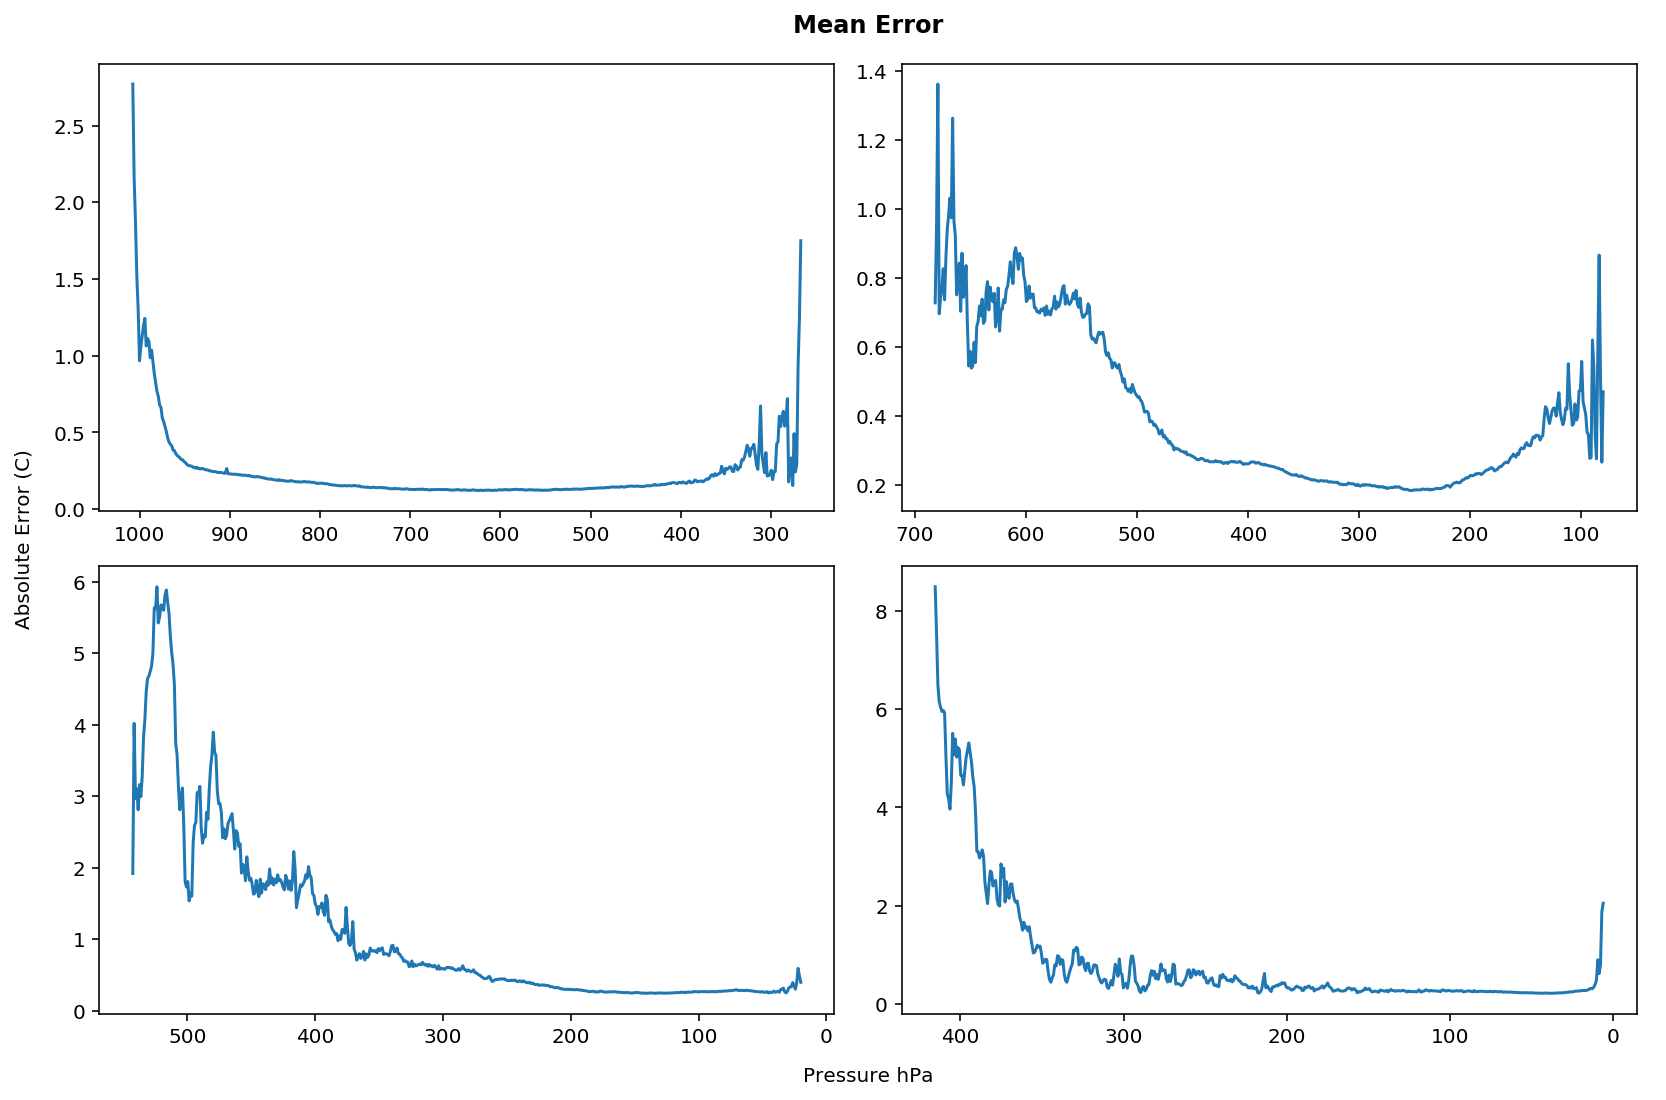

In [39]:
fig, axs = plt.subplots(steps//2, 2, figsize=(12, 8))
axs = axs.ravel()
for i in range(steps):
    axs[i].plot(step_bins[i], step_mean_error[i])
    axs[i].invert_xaxis()
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Pressure hPa', labelpad=10)
plt.ylabel('Absolute Error (C)', labelpad=10)
plt.title('Mean Error', y=1.02, fontweight='bold')

fig.tight_layout();

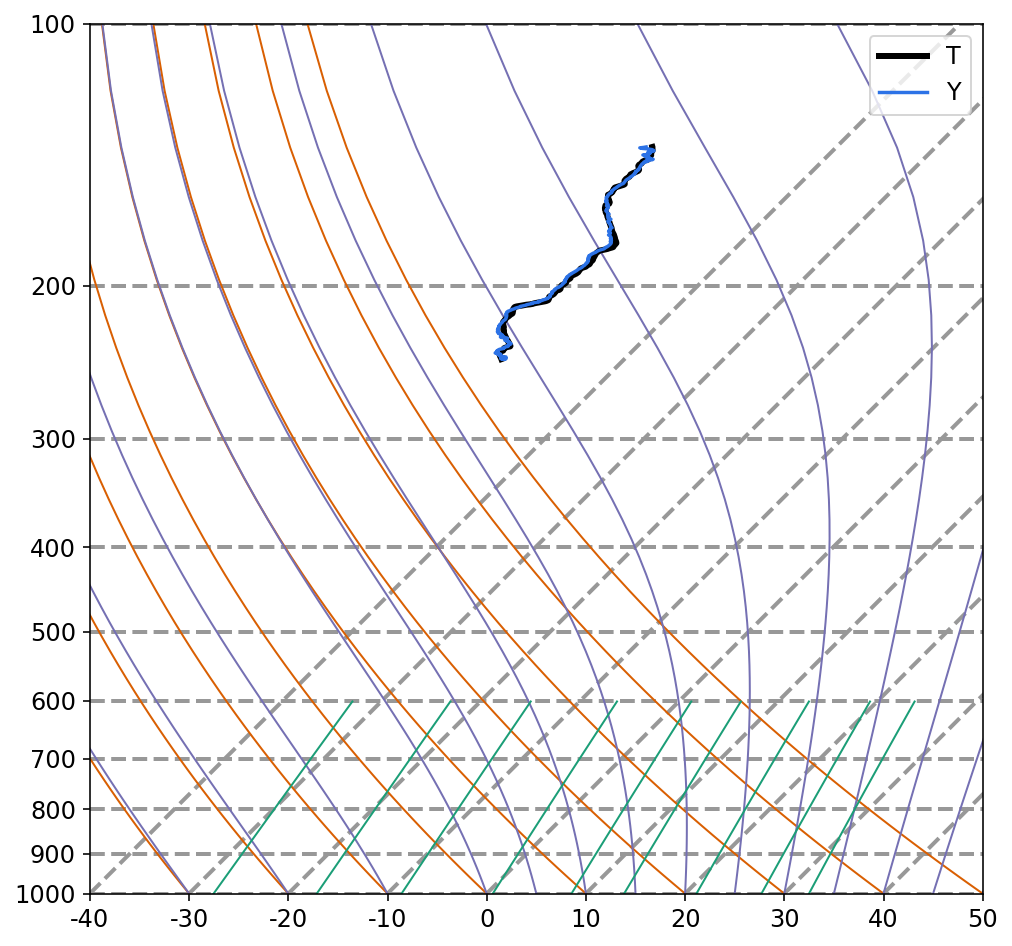

In [59]:
plot_results(nnet, Xtest, Ttest, 13, loss=False)

## Constant Pressure Interpolation